# Quantum energy teleportation less restrictive
https://doi.org/10.48550/arXiv.2502.05288

### Import Packages

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator

from qiskit_aer import AerSimulator

## Model

### Theory

In [2]:
# Parameters
h = 1; k = 1; 

# Define basis
ket_0 = np.array([[1], [0]])
ket_00 = np.kron(ket_0,ket_0)

# Define base operators
I = Operator.from_label('II').to_matrix();
Z_A = Operator.from_label('IZ').to_matrix(); Z_B = Operator.from_label('ZI').to_matrix();
X_AB = Operator.from_label('XX').to_matrix(); X_A = Operator.from_label('IX').to_matrix();
Y_AB = Operator.from_label('YY').to_matrix(); Y_B = Operator.from_label('YI').to_matrix()

# Hamiltonians
H_A = -h*Z_A 
H_B = -h*Z_B 
V = k*(X_AB + Y_AB)

# Define angle Phi
Phi = np.arctan(k/h)/2

# Define operations
def P_A(mi):
    """Projective measurement on qubit 0 or A"""
    return 1/2 * (I + mi*X_A)

def Ry(mi):
    """Conditional unitary operation"""
    return np.cos(Phi) * I - 1j*mi*np.sin(Phi) * Y_B

# Final State Density Matrix
P_QET = np.zeros((4, 4), dtype=complex)
for mi in [-1, 1]:
    P_QET = Ry(-mi)@P_A(mi)@(ket_00@ket_00.conj().T)@P_A(mi)@Ry(-mi).conj().T + P_QET

# Energies
E_Ha = np.trace(P_QET@H_A).real
E_Hb = np.trace(P_QET@H_B).real
E_V = np.trace(P_QET@V).real
E_A = np.trace(P_QET@(H_A+V)).real
E_B = np.trace(P_QET@(H_B+V)).real # or  2*np.sin(theta)**2*np.sqrt(h**2+k**2) 


# Show results
display('Ground State:', Statevector(ket_00).draw('latex'))
display('Final State Density Matrix:', Operator(P_QET).draw('latex'))

print(f"""
Ground State Energies:
<H_A> = {(ket_00.T@H_A@ket_00)[0][0].real},
<H_B> = {(ket_00.T@H_B@ket_00)[0][0].real},
<V>   = {(ket_00.T@V@ket_00)[0][0].real}.
            
Final Energies:
H_A = {E_Ha},
H_B = {E_Hb},
V   = {E_V},
E_A = {E_A},
E_B = {E_B}.
""")

'Ground State:'

<IPython.core.display.Latex object>

'Final State Density Matrix:'

<IPython.core.display.Latex object>


Ground State Energies:
<H_A> = -1.0,
<H_B> = -1.0,
<V>   = 0.0.
            
Final Energies:
H_A = 0.0,
H_B = -0.7071067811865475,
V   = -0.7071067811865476,
E_A = -0.7071067811865476,
E_B = -1.414213562373095.



### Create circuit

In [3]:
def qet(h,k):

    # generate circuit
    qc = QuantumCircuit(2, 2, metadata={'h':h, 'k':k})

    # Measrument*
    qc.h(0)

    qc.barrier()
    # Conditional Operations 
    Phi = np.arctan2(k,h)

    qc.cry(Phi,0,1)
    
    qc.x(0)
    qc.cry(-Phi,0,1)
    qc.x(0)

    qc.barrier()
    return qc

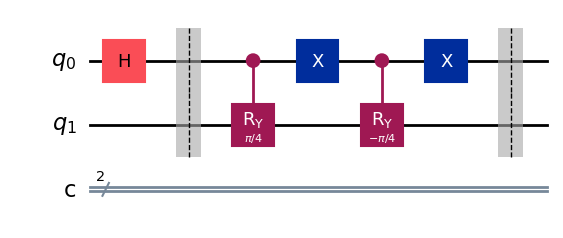

In [4]:
# Show circuit
qet(1,1).draw('mpl')

## Simulate circuit

### Run simulation

In [5]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1; k = 1;
n_shots = 100000

# Generate circuits

# circuit for observable Z
qc_ZZ = qet(h, k)
qc_ZZ.measure_all(add_bits=False)

# circuit for observable XX
qc_XX = qet(h, k)
qc_XX.h(0)
qc_XX.h(1)
qc_XX.measure_all(add_bits=False)

# circuit for observable YY
qc_YY = qet(h,k)
qc_YY.measure(0,1)
qc_YY.h(0)
qc_YY.barrier()
qc_YY.sdg(0)
qc_YY.sdg(1)
qc_YY.h(0)
qc_YY.h(1)
qc_YY.measure_all(add_bits=False)

# Run job
sim_ZZ = simulator.run(qc_ZZ, shots=n_shots)
sim_XX = simulator.run(qc_XX, shots=n_shots)
sim_YY = simulator.run(qc_YY, shots=n_shots)

### Show Results

H_A = -0.0031200000000000394 ± 0.003162262268693095
H_B = -0.70514 ± 0.002242270234383001


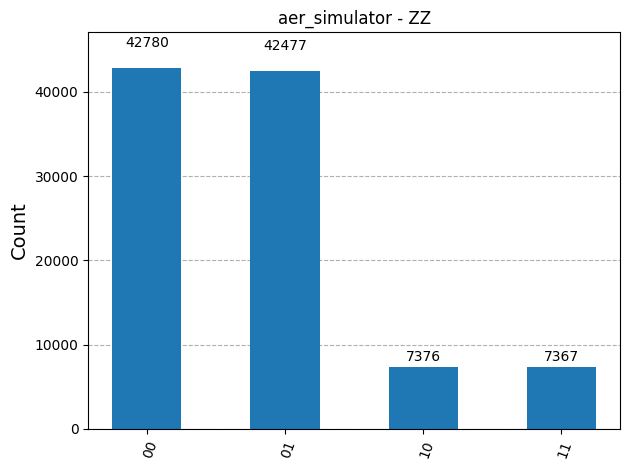

In [6]:
# Extract results
result = sim_ZZ.result()
counts = result.get_counts()

# Energies
ene_A = 0
ene_B = 0

# Error arrays
error_A = []
error_B = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_A += -h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += -h*(-1)**int(bit_string[1])*count/n_shots
        for i in range(count):
            error_A.append(-h*(-1)**int(bit_string[0]))
            error_B.append(-h*(-1)**int(bit_string[1]))

# Show results
print(f"H_A = {ene_A} ± {np.std(error_A)/np.sqrt(n_shots)}")
print(f"H_B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
plot_histogram(counts, title="aer_simulator - ZZ")

V_XX = -0.002219999999999972 ± 0.0031622639934072547


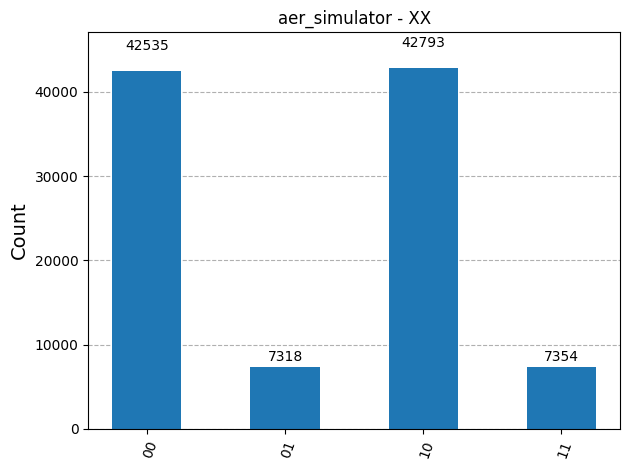

In [7]:
# Extract results
result = sim_XX.result()
counts = result.get_counts()

# Energy
ene_XX = 0

# Error array
error_XX = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_XX += k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots
        for i in range(count):
            error_XX.append(k*(-1)**(int(bit_string[1])))

# Show results
print(f"V_XX = {ene_XX} ± {np.std(error_XX)/np.sqrt(n_shots)}")
plot_histogram(counts, title='aer_simulator - XX')

V_YY = -0.0035600000000000076 ± 0.0031622776196912248


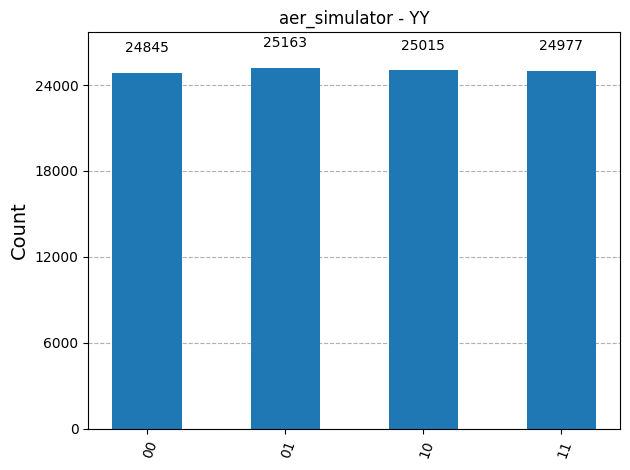

In [8]:
# Extract results
result = sim_YY.result()
counts = result.get_counts()

# Energy
ene_YY = 0

# Error array
error_YY = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_YY += k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots
        for i in range(count):
            error_YY.append(k*(-1)**(int(bit_string[1])))

# Show results
print(f"V_YY = {ene_YY} ± {np.std(error_YY)/np.sqrt(n_shots)}")
plot_histogram(counts, title='aer_simulator - YY')

## Run circuit on hardware

### Import IBM packages

In [ ]:
from qiskit_ibm_runtime import (QiskitRuntimeService, 
                                Batch, 
                                SamplerV2 as sampler, 
                                EstimatorV2 as estimator)
from qiskit.transpiler import preset_passmanagers
from qiskit.quantum_info import SparsePauliOp 

### Get backend

In [ ]:
# Log in IBM platform
service = QiskitRuntimeService()

# Select least busy backend
backend = service.least_busy()
print(backend.name)

### Run job with Sampler

In [ ]:
# Parameters h and k
variables = [(1,1.5), (1,1), (1,0.5), (0.5, 1), (1.5, 1)]
n_shots = 3000

# Run job in Batch mode
with Batch(backend=backend):
    
    # initiate sampler and configure error mitigation
    sampler = sampler()
    options = sampler.options
    options.dynamical_decoupling.enable = True
    options.twirling.enable_gates = True
    options.twirling.enable_measure= True

    for variable in variables:
        h = variable[0]
        k = variable[1]

        # Generate circuits
        circuit_ZZ = qet(h,k)
        circuit_ZZ.measure_all(add_bits=False)
        transpiled_ZZ = transpile(circuit_ZZ, backend=backend, optimization_level=3)

        circuit_XX = qet(h,k)
        circuit_XX.h(0)
        circuit_XX.h(1)
        circuit_XX.measure_all(add_bits=False)
        transpiled_XX = transpile(circuit_XX, backend=backend, optimization_level=3)

        circuit_YY = qet(h,k)
        circuit_YY.measure(0,1)
        circuit_YY.h(0)
        circuit_YY.barrier()
        circuit_YY.sdg(0)
        circuit_YY.sdg(1)
        circuit_YY.h(0)
        circuit_YY.h(1)
        circuit_YY.measure_all(add_bits=False)
        transpiled_YY = transpile(circuit_YY, backend=backend, optimization_level=3)
        
        # Run job
        job_A = sampler.run([(transpiled_ZZ), (transpiled_XX), (transpiled_YY)], shots=n_shots)
        job_A.update_tags([f'k={k},h={h}','error mitigated','sampler','LR',f'{n_shots}'])  # Add tags to job
        print(f"Sampler, ID = {job_A.job_id()}, h = {h} k = {k}")

### Run job with Estimator

In [ ]:
# Parameters h and k
variables = [(1,1.5), (1,1), (1,0.5), (0.5, 1), (1.5, 1)]

# Configure the transpiler
transpiler = preset_passmanagers.generate_preset_pass_manager(optimization_level=3, backend=backend)

# Run job in Batch mode
with Batch(backend=backend):

    for variable in variables:
        h = variable[0]
        k = variable[1]
        observables = [SparsePauliOp('ZI', -h), SparsePauliOp('XX', k), SparsePauliOp('YY', k)]

        # Generate circuit
        circuit_T = qet(h,k)
        circuit_T.measure(0,1)
        circuit_T.h(0)
        transpiled_T = transpiler.run(circuit_T)
        
        # Run job
        transpiled_observables = [observable.apply_layout(transpiled_T.layout) for observable in observables]
        job_B = estimator(options={'resilience_level':2}).run([(transpiled_T, transpiled_observables)]) # transpiled_observables[0] [1] or [2] to run separately
        job_B.update_tags([f'k={k},h={h}','error mitigated','estimator','LR']) # Add tags
        print(f"Estimator, ID = {job_B.job_id()}, h = {h} k = {k}") 


### Results

### Show results for circuit H

In [ ]:
# Extract results

# Sampler
jobS = service.job("")
result = jobS.result()[0]
counts = result.data.c.get_counts()
n_shots = result.data.c.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
est_B = result.data.evs[0]
value_error = result.data.stds[0]

# Parameters
metadata = result.metadata.get('circuit_metadata')
h = metadata.get('h')
k = metadata.get('k')

# Energy
ene_B = 0

# Error array
error_B = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]  # Invert bits ordering 
        ene_B += -h*(-1)**int(bit_string[1])*count/n_shots
        for i in range(count):
            error_B.append(-h*(-1)**int(bit_string[1]))

# Print results
print(f"  Sampler H_B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
print(f"Estimator H_B = {est_B} ± {value_error}")
plot_histogram(counts, title=f"{jobS.backend().name} - H")

### Show results for circuit XX

In [ ]:
# Extract results

# Sampler
jobS = service.job('')
result = jobS.result()[1]
counts = result.data.c.get_counts()
n_shots = result.data.c.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
est_XX= result.data.evs[1]
value_error = result.data.stds[1]

# Parameters
metadata = result.metadata.get('circuit_metadata')
h = metadata.get('h')
k = metadata.get('k')

# Energy
ene_XX = 0

# Error array
error_XX = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]   # Invert bits ordering
        ene_XX += k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots   
        for i in range(count):
            error_XX.append(k*(-1)**(int(bit_string[1])))                             

# Show results
print(f"  Sampler XX = {ene_XX} ± {np.std(error_XX)/np.sqrt(n_shots)}")
print(f"Estimated XX = {est_XX} ± {value_error}")
plot_histogram(counts, title=f"{jobS.backend().name} - XX")

### Show results for circuit YY

In [ ]:
# Extract results

# Sampler
jobS = service.job('')
result = jobS.result()[2]
counts = result.data.c.get_counts()
n_shots = result.data.c.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
est_YY = result.data.evs[2]
value_error = result.data.stds[2]

# Parameters
metadata = result.metadata.get('circuit_metadata')
h = metadata.get('h')
k = metadata.get('k')

# Energy
ene_YY = 0

# Error array
error_YY = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]  # Invert bits ordering
        ene_YY += k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots   
        for i in range(count):
            error_YY.append(k*(-1)**(int(bit_string[1])))                              

# Show results
print(f"  Sampler YY = {ene_YY} ± {np.std(error_YY)/np.sqrt(n_shots)}")
print(f"Estimated YY = {est_YY} ± {value_error}")
plot_histogram(counts, title=f"{jobS.backend().name} - YY")